In [1]:
# example of training a stable gan for generating a handwritten digit
from os import makedirs
from numpy import expand_dims, zeros, ones
from numpy.random import randn, randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    # weight initialization
    # init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same',
                     input_shape=in_shape))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', ))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Dropout(0.4))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [13]:
# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    # init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 512*7*7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,512)))
    # upsample to 14x14
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', ))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', ))
    model.add(LeakyReLU(alpha=0.2))
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same',))
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
# load mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy),(_,_) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # select all of the examples for a given class
    selected_ix = trainy == 8
    X = X[selected_ix]
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X-127.5)/127.5
    return X

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples,1))
    return X,y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X,y

In [9]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X+1)/2.0
    # plot images
    pyplot.figure(figsize=(20,20))
    for i in range(10*10):
        # define subplot
        pyplot.subplot(10,10,1+i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i,:,:,0], cmap='gray_r')
    # save plot to file
    pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
    pyplot.show()
    pyplot.close()
    # save the generator model
    g_model.save('results_baseline/model_%03d.h5' % (step+1))

In [10]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2,1,1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2,1,2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    pyplot.show()
    pyplot.close()

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0]/n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch/2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as inputs for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch,1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f, g=%.3f, a1=%d, a2=%d' % 
              (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
        # record history
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # evaluate the model performance every 'epoch'
        if (i+1)% bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)

(5851, 28, 28, 1)
>1, d1=0.802, d2=0.694, g=0.693, a1=6, a2=18
>2, d1=0.697, d2=0.697, g=0.690, a1=48, a2=0
>3, d1=0.623, d2=0.700, g=0.687, a1=87, a2=1
>4, d1=0.546, d2=0.706, g=0.682, a1=100, a2=0
>5, d1=0.483, d2=0.714, g=0.675, a1=100, a2=0
>6, d1=0.412, d2=0.731, g=0.661, a1=100, a2=0
>7, d1=0.355, d2=0.771, g=0.635, a1=100, a2=0
>8, d1=0.302, d2=0.827, g=0.594, a1=100, a2=0
>9, d1=0.283, d2=0.931, g=0.527, a1=100, a2=0
>10, d1=0.275, d2=1.043, g=0.486, a1=100, a2=0
>11, d1=0.284, d2=1.071, g=0.495, a1=100, a2=0
>12, d1=0.317, d2=0.988, g=0.557, a1=100, a2=0
>13, d1=0.361, d2=0.899, g=0.631, a1=100, a2=1
>14, d1=0.378, d2=0.759, g=0.727, a1=100, a2=21
>15, d1=0.401, d2=0.675, g=0.794, a1=100, a2=57
>16, d1=0.405, d2=0.612, g=0.888, a1=98, a2=82
>17, d1=0.432, d2=0.540, g=0.972, a1=100, a2=95
>18, d1=0.439, d2=0.497, g=1.036, a1=96, a2=100
>19, d1=0.418, d2=0.450, g=1.129, a1=96, a2=100
>20, d1=0.402, d2=0.431, g=1.204, a1=100, a2=98
>21, d1=0.429, d2=0.396, g=1.262, a1=93, a2=100


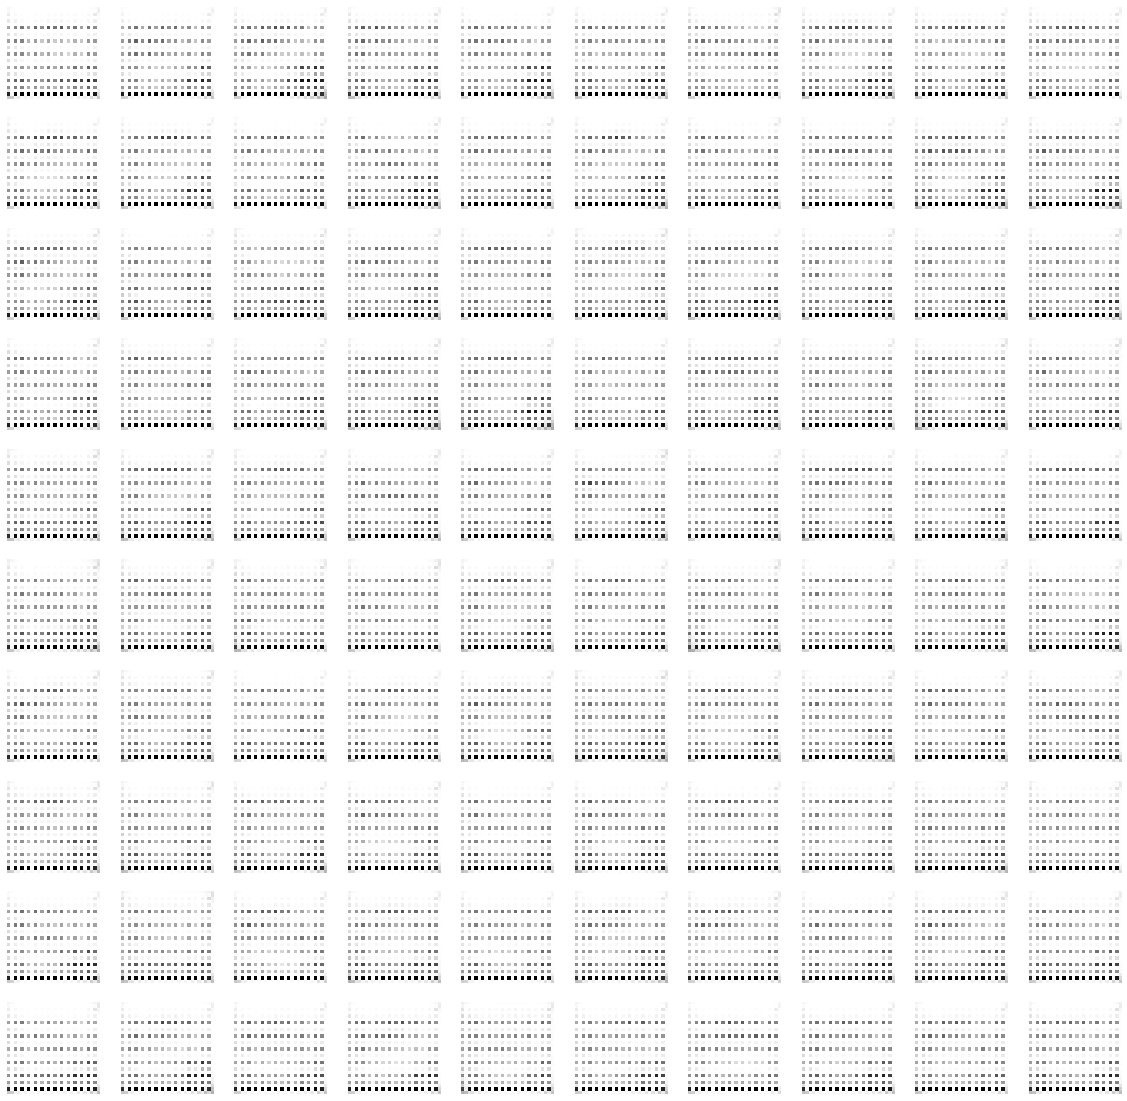

>46, d1=0.108, d2=0.097, g=2.721, a1=100, a2=100
>47, d1=0.077, d2=0.199, g=2.059, a1=100, a2=100
>48, d1=0.103, d2=0.151, g=2.218, a1=98, a2=100
>49, d1=0.098, d2=0.120, g=2.391, a1=100, a2=100
>50, d1=0.093, d2=0.094, g=2.583, a1=98, a2=100
>51, d1=0.077, d2=0.081, g=2.760, a1=100, a2=100
>52, d1=0.089, d2=0.079, g=2.845, a1=98, a2=100
>53, d1=0.107, d2=0.064, g=2.878, a1=96, a2=100
>54, d1=0.099, d2=0.074, g=3.002, a1=96, a2=100
>55, d1=0.048, d2=0.061, g=3.046, a1=100, a2=100
>56, d1=0.035, d2=0.053, g=3.145, a1=100, a2=100
>57, d1=0.051, d2=0.046, g=3.364, a1=100, a2=100
>58, d1=0.043, d2=0.038, g=3.370, a1=100, a2=100
>59, d1=0.036, d2=0.042, g=3.471, a1=100, a2=100
>60, d1=0.054, d2=0.033, g=3.569, a1=98, a2=100
>61, d1=0.046, d2=0.034, g=3.565, a1=100, a2=100
>62, d1=0.030, d2=0.032, g=3.757, a1=100, a2=100
>63, d1=0.024, d2=0.029, g=3.747, a1=100, a2=100
>64, d1=0.046, d2=0.026, g=3.837, a1=98, a2=100
>65, d1=0.017, d2=0.025, g=3.899, a1=100, a2=100
>66, d1=0.024, d2=0.023, g=

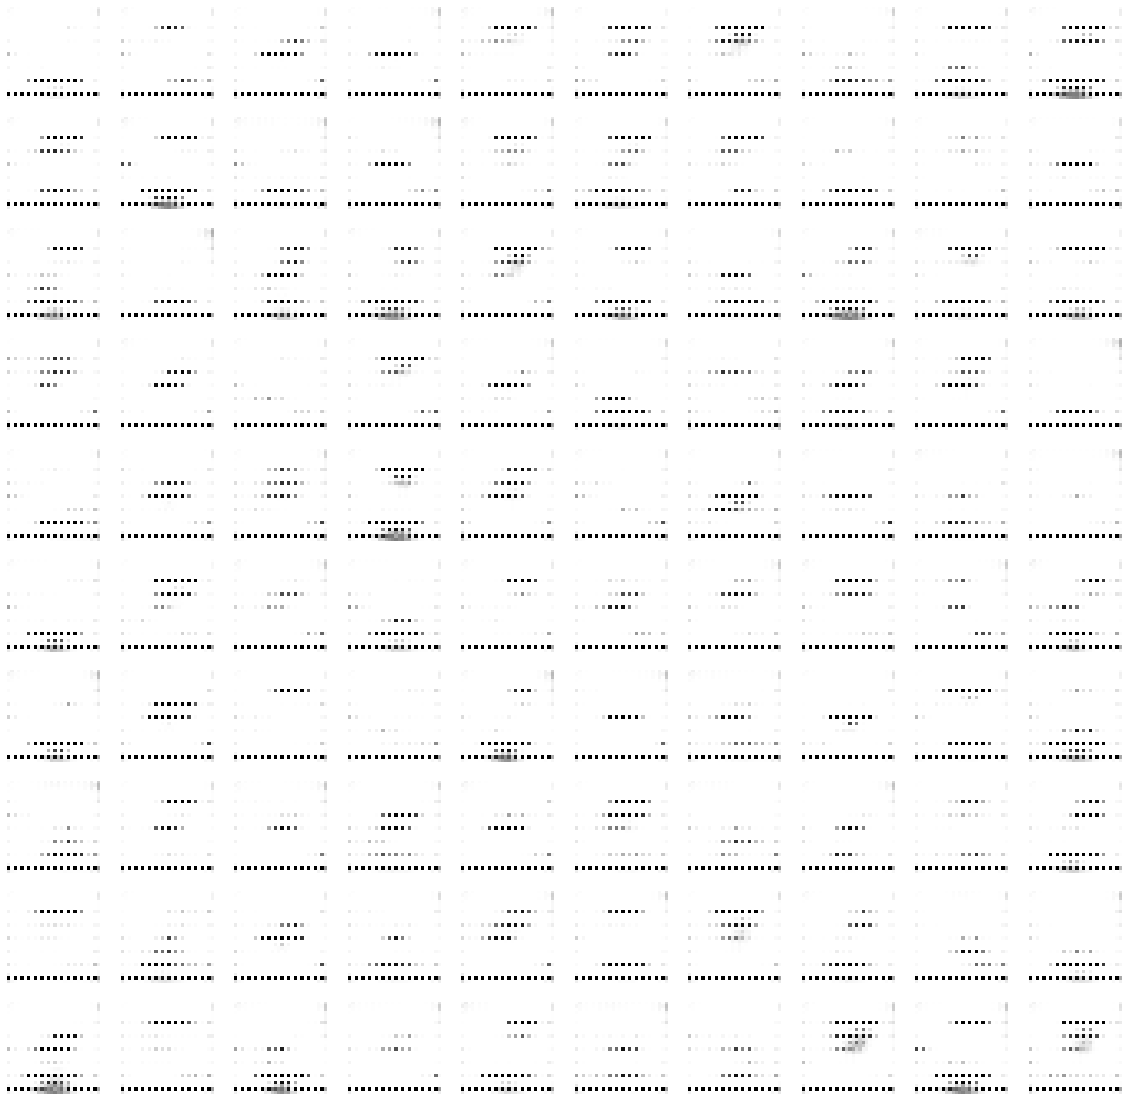

>91, d1=0.014, d2=0.014, g=4.881, a1=100, a2=100
>92, d1=0.043, d2=0.016, g=4.550, a1=98, a2=100
>93, d1=0.016, d2=0.017, g=4.621, a1=100, a2=100
>94, d1=0.017, d2=0.016, g=4.513, a1=100, a2=100
>95, d1=0.020, d2=0.020, g=4.541, a1=100, a2=100
>96, d1=0.019, d2=0.201, g=4.084, a1=100, a2=92
>97, d1=0.082, d2=1.730, g=1.790, a1=96, a2=1
>98, d1=0.312, d2=2.475, g=0.426, a1=85, a2=0
>99, d1=0.440, d2=5.513, g=0.037, a1=79, a2=0
>100, d1=0.224, d2=2.871, g=0.251, a1=85, a2=0
>101, d1=0.095, d2=1.167, g=0.881, a1=93, a2=4
>102, d1=0.043, d2=0.395, g=1.658, a1=100, a2=98
>103, d1=0.026, d2=0.202, g=2.102, a1=100, a2=100
>104, d1=0.015, d2=0.137, g=2.444, a1=100, a2=100
>105, d1=0.020, d2=0.092, g=2.747, a1=100, a2=100
>106, d1=0.020, d2=0.083, g=2.786, a1=100, a2=100
>107, d1=0.015, d2=0.089, g=2.598, a1=100, a2=100
>108, d1=0.017, d2=0.115, g=2.597, a1=100, a2=100
>109, d1=0.017, d2=0.096, g=2.688, a1=100, a2=100
>110, d1=0.015, d2=0.077, g=2.800, a1=100, a2=100
>111, d1=0.021, d2=0.080, g

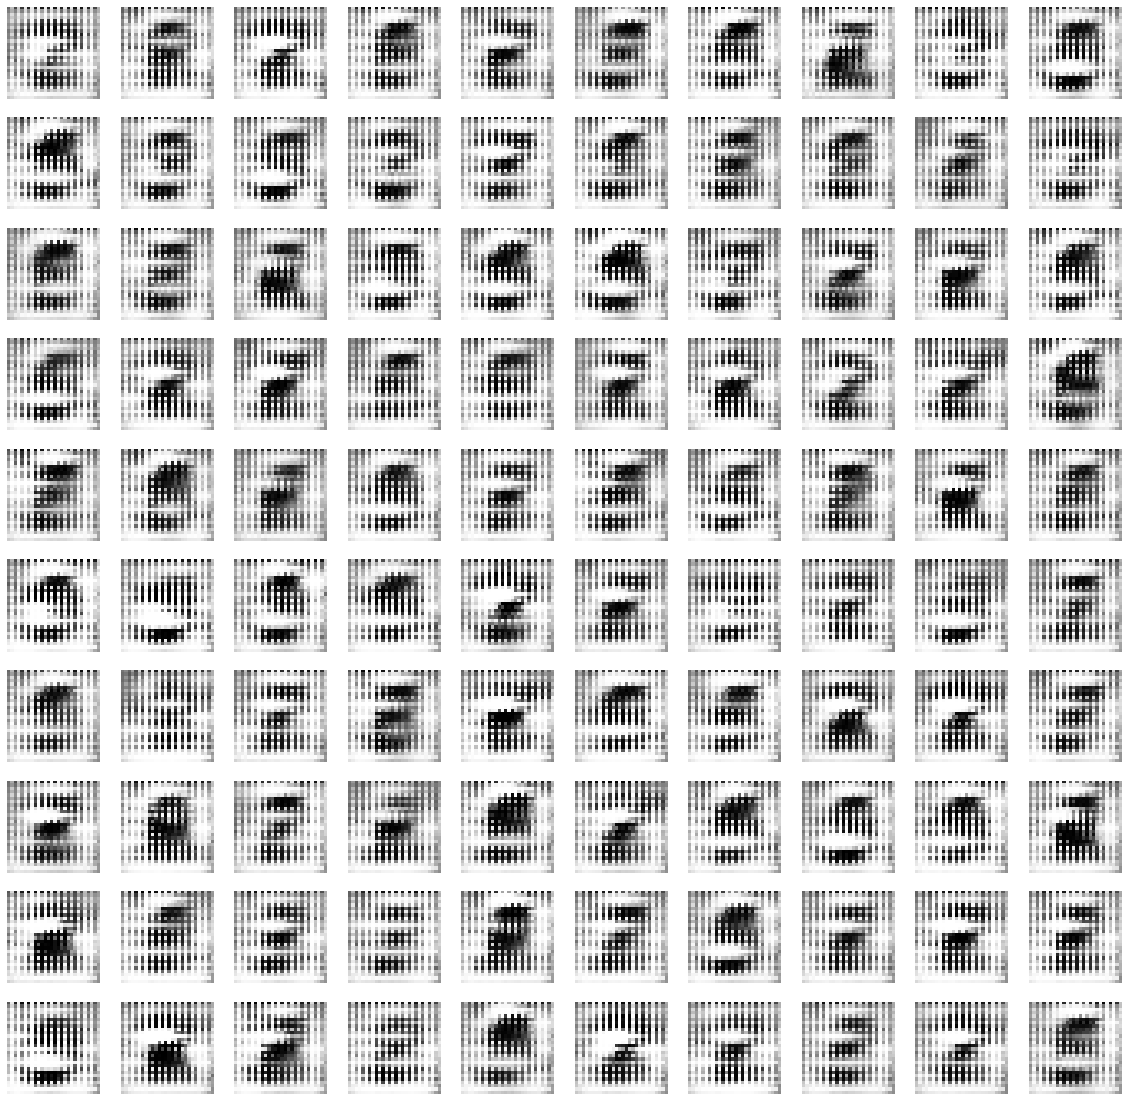

>136, d1=0.484, d2=0.759, g=1.033, a1=75, a2=50
>137, d1=0.393, d2=0.731, g=0.957, a1=90, a2=48
>138, d1=0.375, d2=0.730, g=1.109, a1=82, a2=53
>139, d1=0.516, d2=0.718, g=1.057, a1=78, a2=53
>140, d1=0.555, d2=0.724, g=0.971, a1=75, a2=48
>141, d1=0.520, d2=0.769, g=1.075, a1=76, a2=53
>142, d1=0.567, d2=0.754, g=1.148, a1=78, a2=51
>143, d1=0.622, d2=0.726, g=1.073, a1=65, a2=48
>144, d1=0.708, d2=0.700, g=1.007, a1=56, a2=57
>145, d1=0.570, d2=0.789, g=1.040, a1=70, a2=42
>146, d1=0.652, d2=0.677, g=1.112, a1=65, a2=57
>147, d1=0.652, d2=0.685, g=1.019, a1=64, a2=57
>148, d1=0.710, d2=0.729, g=0.984, a1=54, a2=56
>149, d1=0.653, d2=0.759, g=1.004, a1=70, a2=40
>150, d1=0.665, d2=0.715, g=0.934, a1=51, a2=51
>151, d1=0.619, d2=0.734, g=0.998, a1=70, a2=48
>152, d1=0.724, d2=0.726, g=0.965, a1=56, a2=50
>153, d1=0.771, d2=0.770, g=0.898, a1=56, a2=40
>154, d1=0.771, d2=0.832, g=0.818, a1=48, a2=34
>155, d1=0.716, d2=0.841, g=0.805, a1=54, a2=37
>156, d1=0.787, d2=0.821, g=0.768, a1=51

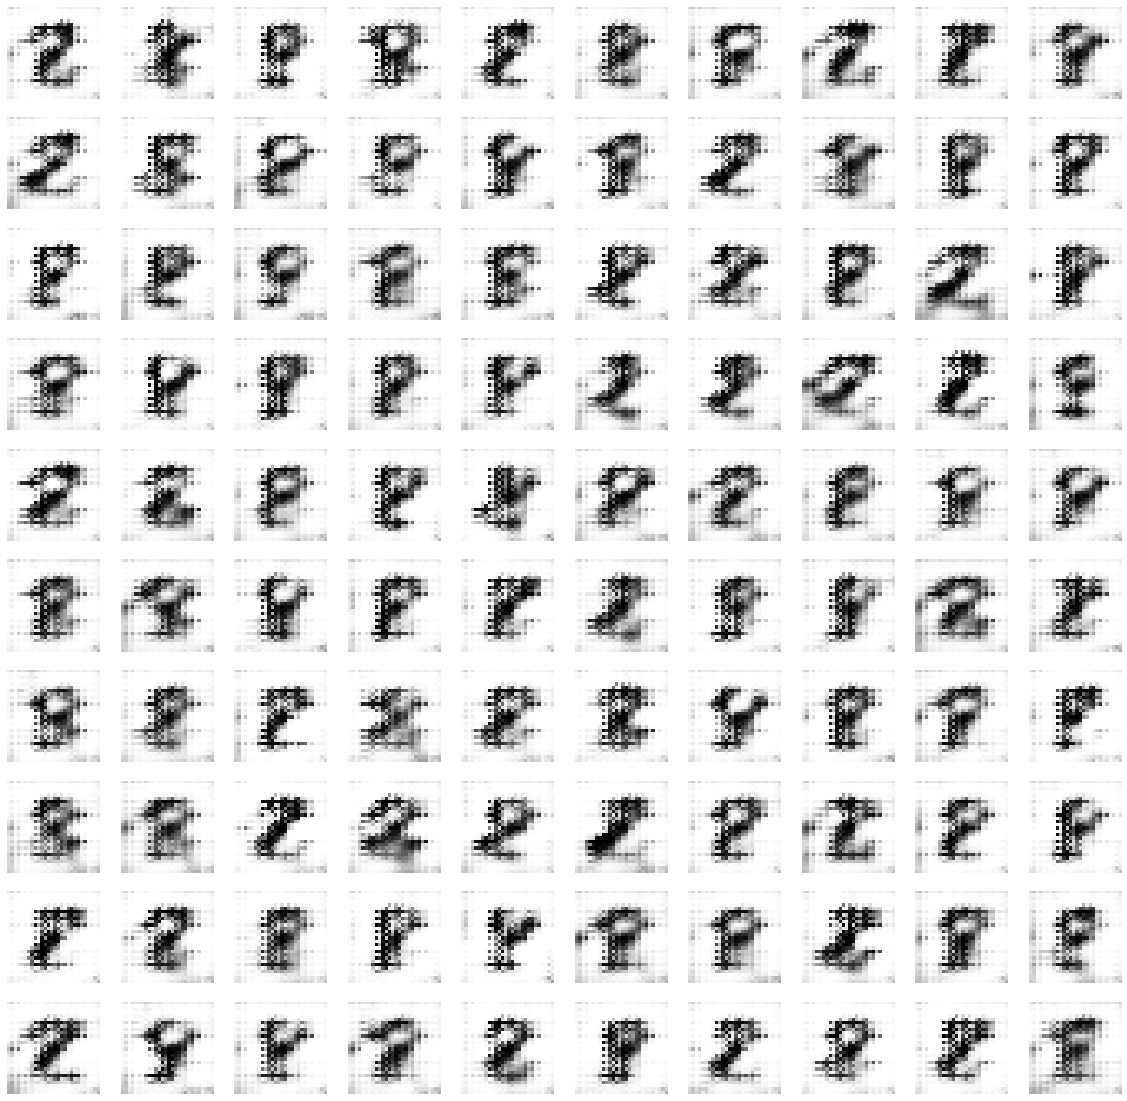

>181, d1=0.720, d2=0.871, g=0.701, a1=51, a2=18
>182, d1=0.668, d2=0.841, g=0.699, a1=65, a2=25
>183, d1=0.707, d2=0.870, g=0.722, a1=51, a2=18
>184, d1=0.711, d2=0.850, g=0.680, a1=46, a2=20
>185, d1=0.666, d2=0.827, g=0.712, a1=59, a2=21
>186, d1=0.692, d2=0.810, g=0.722, a1=50, a2=26
>187, d1=0.638, d2=0.777, g=0.716, a1=60, a2=35
>188, d1=0.745, d2=0.794, g=0.707, a1=53, a2=25
>189, d1=0.704, d2=0.824, g=0.730, a1=57, a2=25
>190, d1=0.668, d2=0.764, g=0.720, a1=67, a2=42
>191, d1=0.680, d2=0.753, g=0.711, a1=59, a2=40
>192, d1=0.706, d2=0.838, g=0.698, a1=53, a2=21
>193, d1=0.748, d2=0.829, g=0.686, a1=42, a2=18
>194, d1=0.625, d2=0.785, g=0.715, a1=67, a2=28
>195, d1=0.713, d2=0.832, g=0.687, a1=51, a2=20
>196, d1=0.737, d2=0.838, g=0.701, a1=50, a2=21
>197, d1=0.735, d2=0.816, g=0.721, a1=50, a2=21
>198, d1=0.757, d2=0.831, g=0.694, a1=42, a2=23
>199, d1=0.674, d2=0.766, g=0.722, a1=59, a2=31
>200, d1=0.682, d2=0.749, g=0.740, a1=48, a2=35
>201, d1=0.687, d2=0.746, g=0.734, a1=57

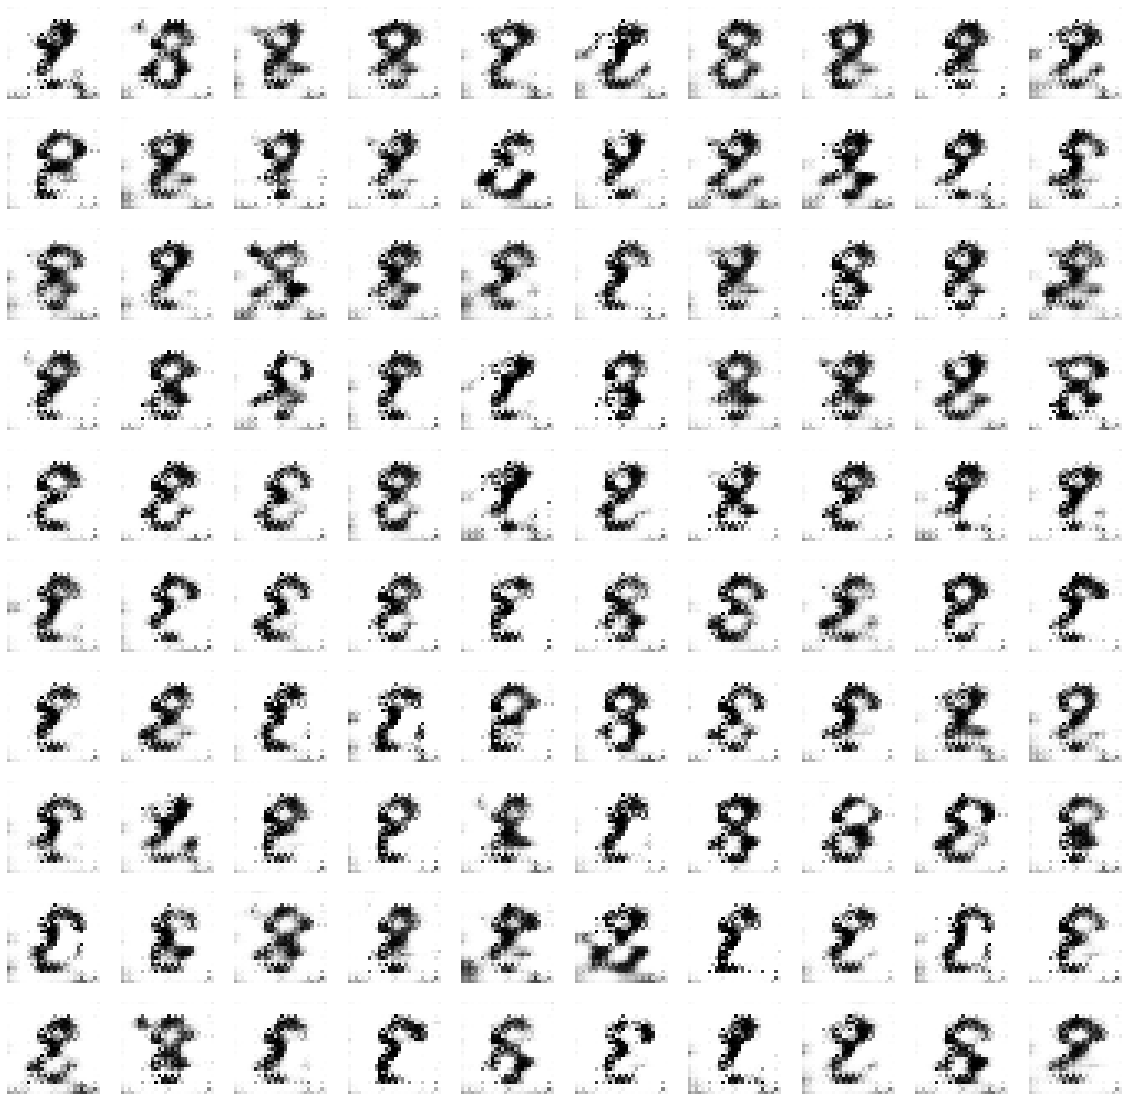

>226, d1=0.634, d2=0.739, g=0.757, a1=60, a2=34
>227, d1=0.666, d2=0.728, g=0.758, a1=56, a2=43
>228, d1=0.706, d2=0.706, g=0.770, a1=53, a2=50
>229, d1=0.708, d2=0.706, g=0.760, a1=50, a2=51
>230, d1=0.662, d2=0.761, g=0.770, a1=62, a2=34
>231, d1=0.715, d2=0.750, g=0.752, a1=53, a2=35
>232, d1=0.713, d2=0.740, g=0.760, a1=57, a2=40
>233, d1=0.679, d2=0.728, g=0.760, a1=54, a2=40
>234, d1=0.685, d2=0.763, g=0.765, a1=53, a2=34
>235, d1=0.699, d2=0.739, g=0.767, a1=50, a2=43
>236, d1=0.676, d2=0.713, g=0.786, a1=54, a2=40
>237, d1=0.697, d2=0.722, g=0.722, a1=56, a2=45
>238, d1=0.682, d2=0.731, g=0.781, a1=59, a2=45
>239, d1=0.692, d2=0.730, g=0.740, a1=57, a2=48
>240, d1=0.698, d2=0.743, g=0.798, a1=50, a2=43
>241, d1=0.695, d2=0.736, g=0.764, a1=48, a2=46
>242, d1=0.717, d2=0.726, g=0.775, a1=42, a2=48
>243, d1=0.665, d2=0.687, g=0.798, a1=60, a2=54
>244, d1=0.734, d2=0.702, g=0.802, a1=50, a2=57
>245, d1=0.708, d2=0.715, g=0.814, a1=53, a2=48
>246, d1=0.692, d2=0.665, g=0.827, a1=60

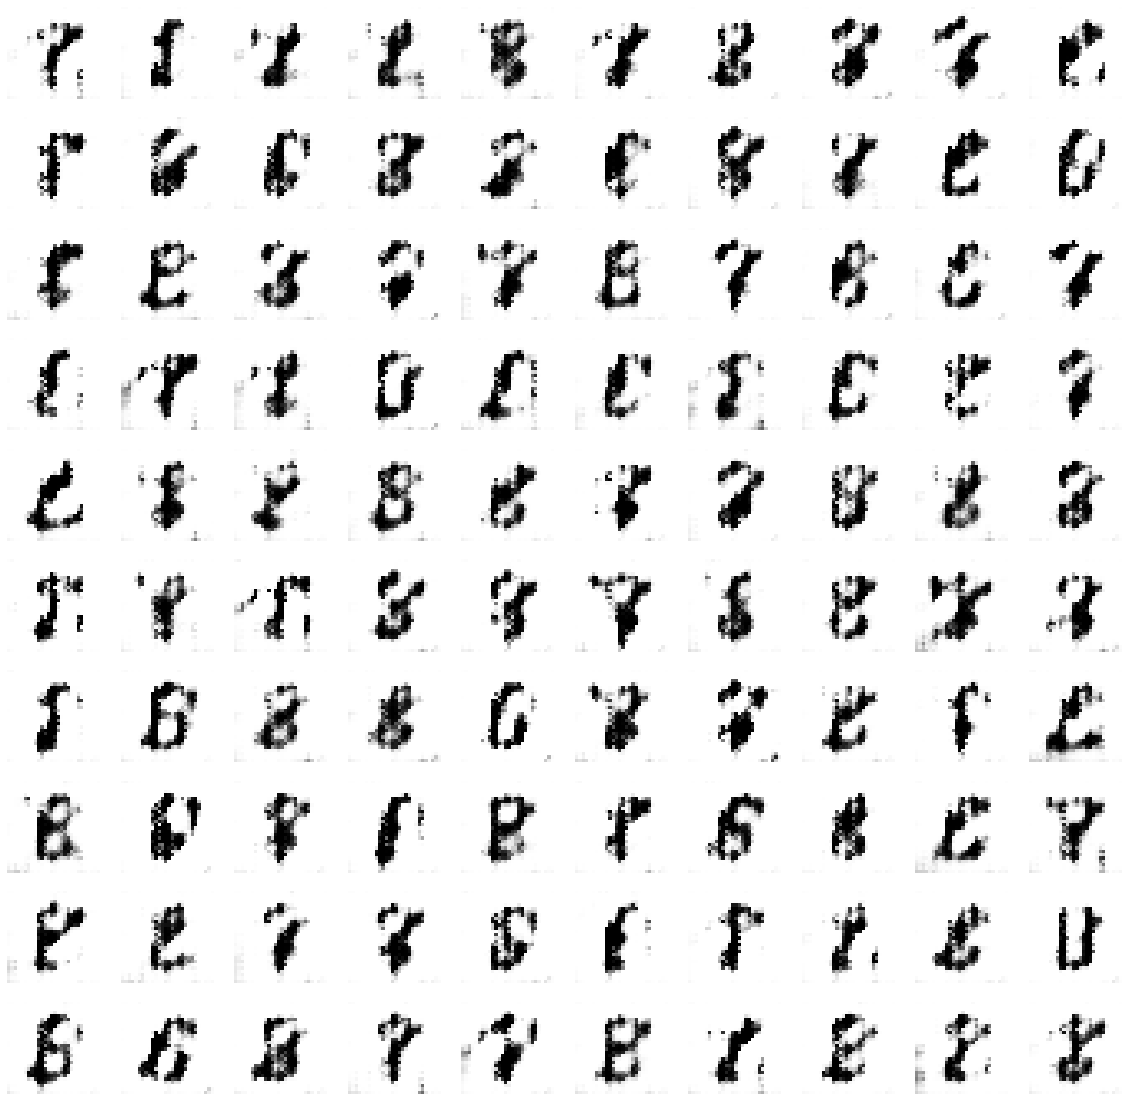

>271, d1=0.665, d2=0.709, g=0.762, a1=67, a2=43
>272, d1=0.675, d2=0.698, g=0.735, a1=54, a2=51
>273, d1=0.652, d2=0.673, g=0.742, a1=65, a2=59
>274, d1=0.640, d2=0.689, g=0.791, a1=68, a2=48
>275, d1=0.691, d2=0.684, g=0.781, a1=54, a2=59
>276, d1=0.691, d2=0.697, g=0.788, a1=53, a2=57
>277, d1=0.650, d2=0.684, g=0.813, a1=62, a2=48
>278, d1=0.662, d2=0.682, g=0.780, a1=54, a2=57
>279, d1=0.672, d2=0.673, g=0.794, a1=56, a2=67
>280, d1=0.659, d2=0.661, g=0.783, a1=64, a2=64
>281, d1=0.646, d2=0.655, g=0.800, a1=67, a2=65
>282, d1=0.714, d2=0.681, g=0.800, a1=43, a2=56
>283, d1=0.651, d2=0.677, g=0.791, a1=67, a2=62
>284, d1=0.638, d2=0.681, g=0.817, a1=68, a2=57
>285, d1=0.652, d2=0.672, g=0.797, a1=59, a2=60
>286, d1=0.650, d2=0.648, g=0.834, a1=67, a2=68
>287, d1=0.653, d2=0.666, g=0.800, a1=60, a2=56
>288, d1=0.634, d2=0.659, g=0.799, a1=67, a2=59
>289, d1=0.662, d2=0.660, g=0.817, a1=67, a2=60
>290, d1=0.655, d2=0.676, g=0.795, a1=57, a2=62
>291, d1=0.662, d2=0.680, g=0.776, a1=59

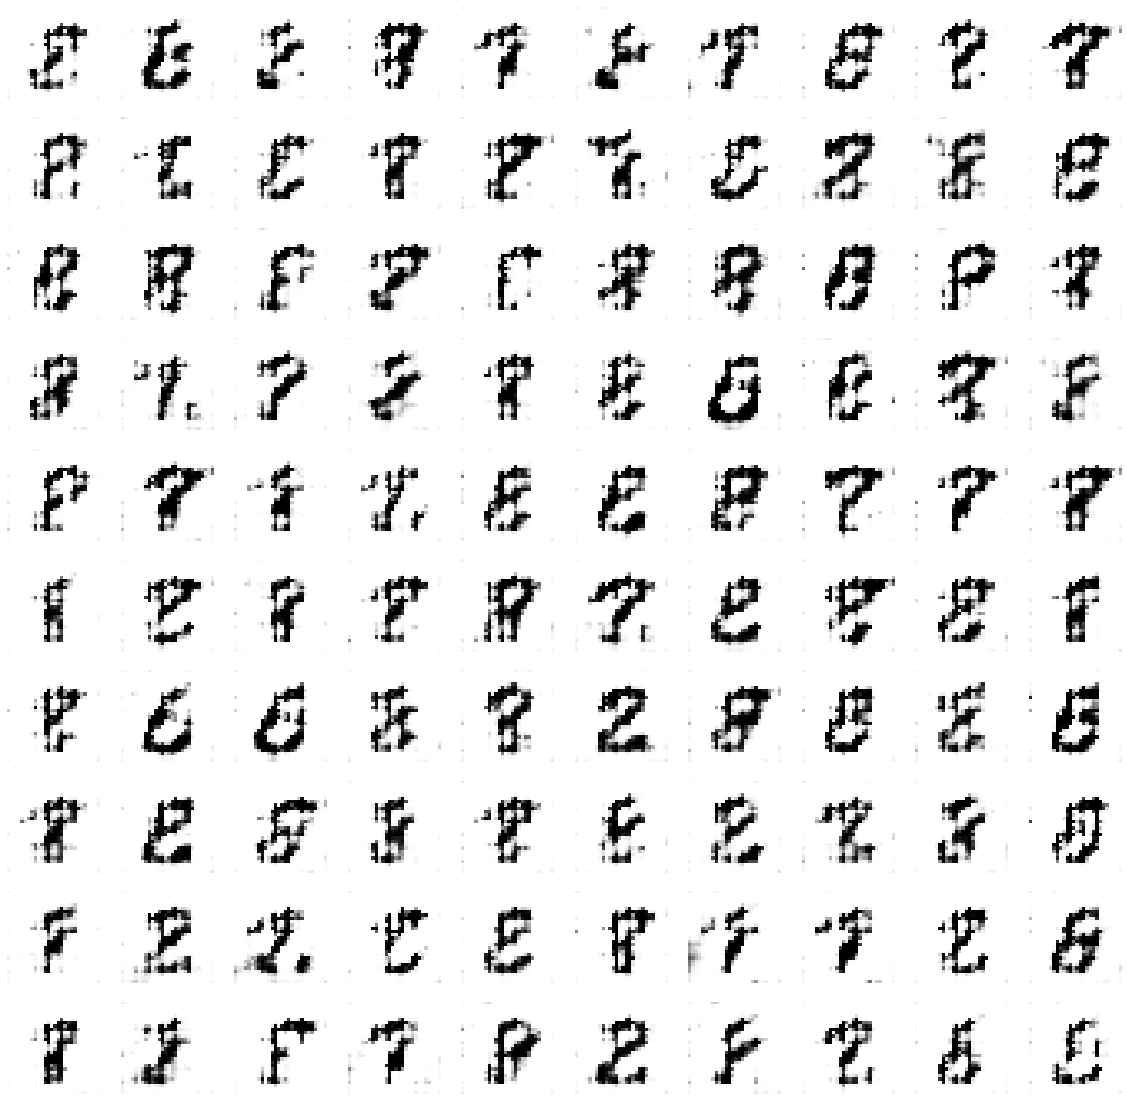

>316, d1=0.714, d2=0.681, g=0.738, a1=51, a2=57
>317, d1=0.714, d2=0.710, g=0.758, a1=53, a2=48
>318, d1=0.759, d2=0.694, g=0.751, a1=34, a2=56
>319, d1=0.742, d2=0.664, g=0.784, a1=42, a2=62
>320, d1=0.709, d2=0.656, g=0.793, a1=46, a2=67
>321, d1=0.730, d2=0.678, g=0.821, a1=45, a2=62
>322, d1=0.684, d2=0.632, g=0.822, a1=53, a2=75
>323, d1=0.710, d2=0.643, g=0.838, a1=57, a2=73
>324, d1=0.706, d2=0.605, g=0.852, a1=53, a2=81
>325, d1=0.683, d2=0.617, g=0.864, a1=64, a2=68
>326, d1=0.697, d2=0.597, g=0.874, a1=43, a2=75
>327, d1=0.683, d2=0.594, g=0.898, a1=57, a2=78
>328, d1=0.693, d2=0.612, g=0.891, a1=50, a2=71
>329, d1=0.649, d2=0.595, g=0.861, a1=67, a2=84
>330, d1=0.664, d2=0.602, g=0.886, a1=62, a2=85
>331, d1=0.639, d2=0.628, g=0.815, a1=67, a2=73
>332, d1=0.663, d2=0.654, g=0.848, a1=57, a2=59
>333, d1=0.653, d2=0.631, g=0.813, a1=68, a2=68
>334, d1=0.649, d2=0.624, g=0.840, a1=60, a2=71
>335, d1=0.678, d2=0.647, g=0.786, a1=57, a2=70
>336, d1=0.667, d2=0.679, g=0.821, a1=64

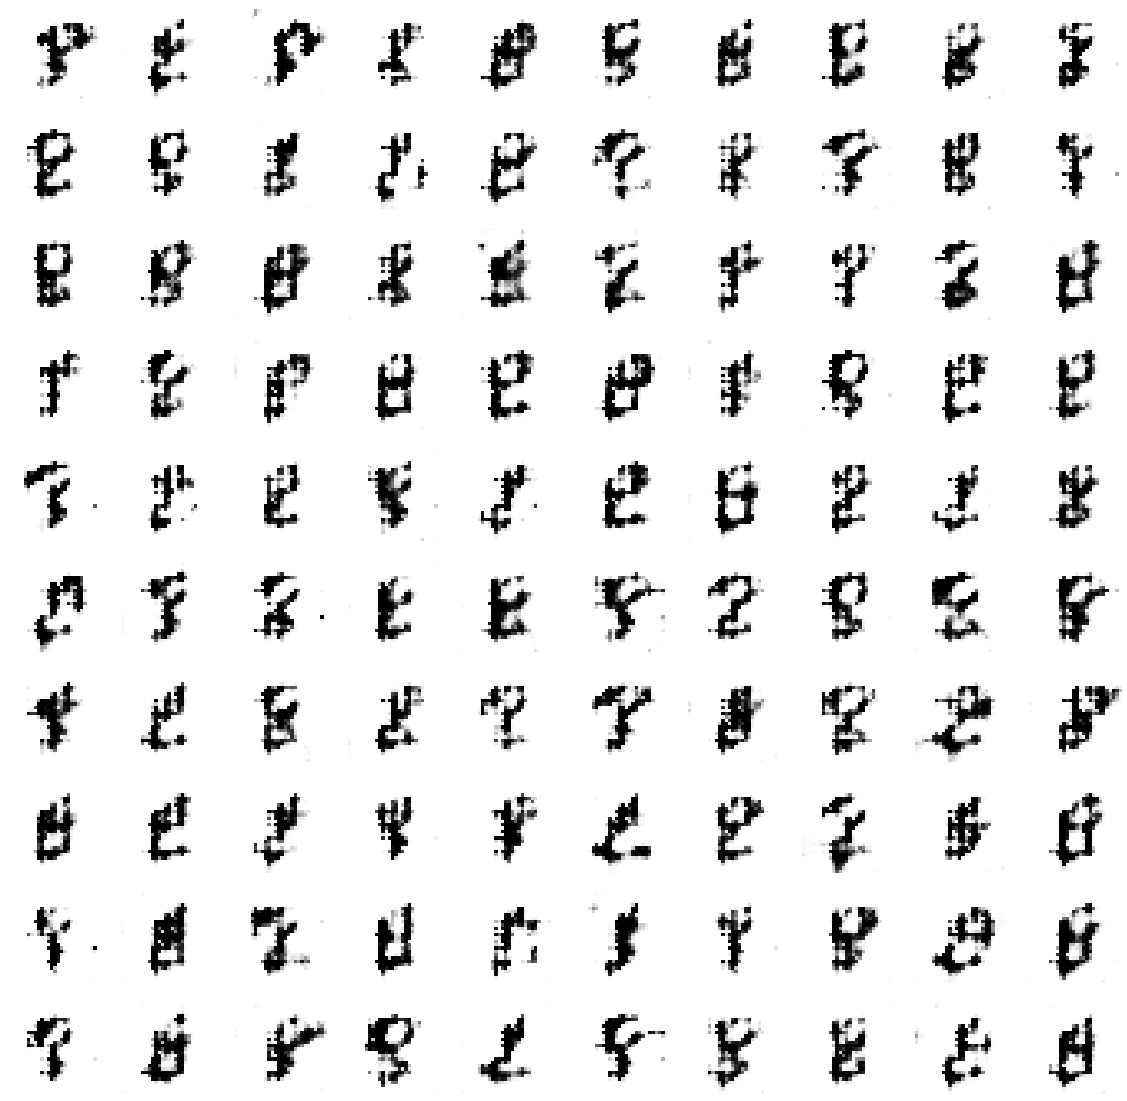

>361, d1=0.670, d2=0.674, g=0.778, a1=57, a2=53
>362, d1=0.716, d2=0.714, g=0.775, a1=43, a2=53
>363, d1=0.693, d2=0.675, g=0.782, a1=46, a2=59
>364, d1=0.692, d2=0.681, g=0.809, a1=50, a2=56
>365, d1=0.678, d2=0.663, g=0.798, a1=59, a2=65
>366, d1=0.645, d2=0.663, g=0.806, a1=65, a2=60
>367, d1=0.661, d2=0.659, g=0.807, a1=60, a2=64
>368, d1=0.648, d2=0.629, g=0.809, a1=59, a2=68
>369, d1=0.654, d2=0.624, g=0.842, a1=60, a2=76
>370, d1=0.678, d2=0.655, g=0.827, a1=57, a2=71
>371, d1=0.691, d2=0.643, g=0.808, a1=53, a2=62
>372, d1=0.670, d2=0.612, g=0.827, a1=53, a2=79
>373, d1=0.674, d2=0.646, g=0.792, a1=54, a2=65
>374, d1=0.650, d2=0.648, g=0.808, a1=71, a2=71
>375, d1=0.618, d2=0.670, g=0.817, a1=75, a2=62
>376, d1=0.682, d2=0.673, g=0.829, a1=57, a2=54
>377, d1=0.658, d2=0.653, g=0.815, a1=62, a2=60
>378, d1=0.639, d2=0.655, g=0.792, a1=68, a2=73
>379, d1=0.661, d2=0.668, g=0.796, a1=54, a2=67
>380, d1=0.715, d2=0.713, g=0.736, a1=50, a2=51
>381, d1=0.662, d2=0.716, g=0.760, a1=73

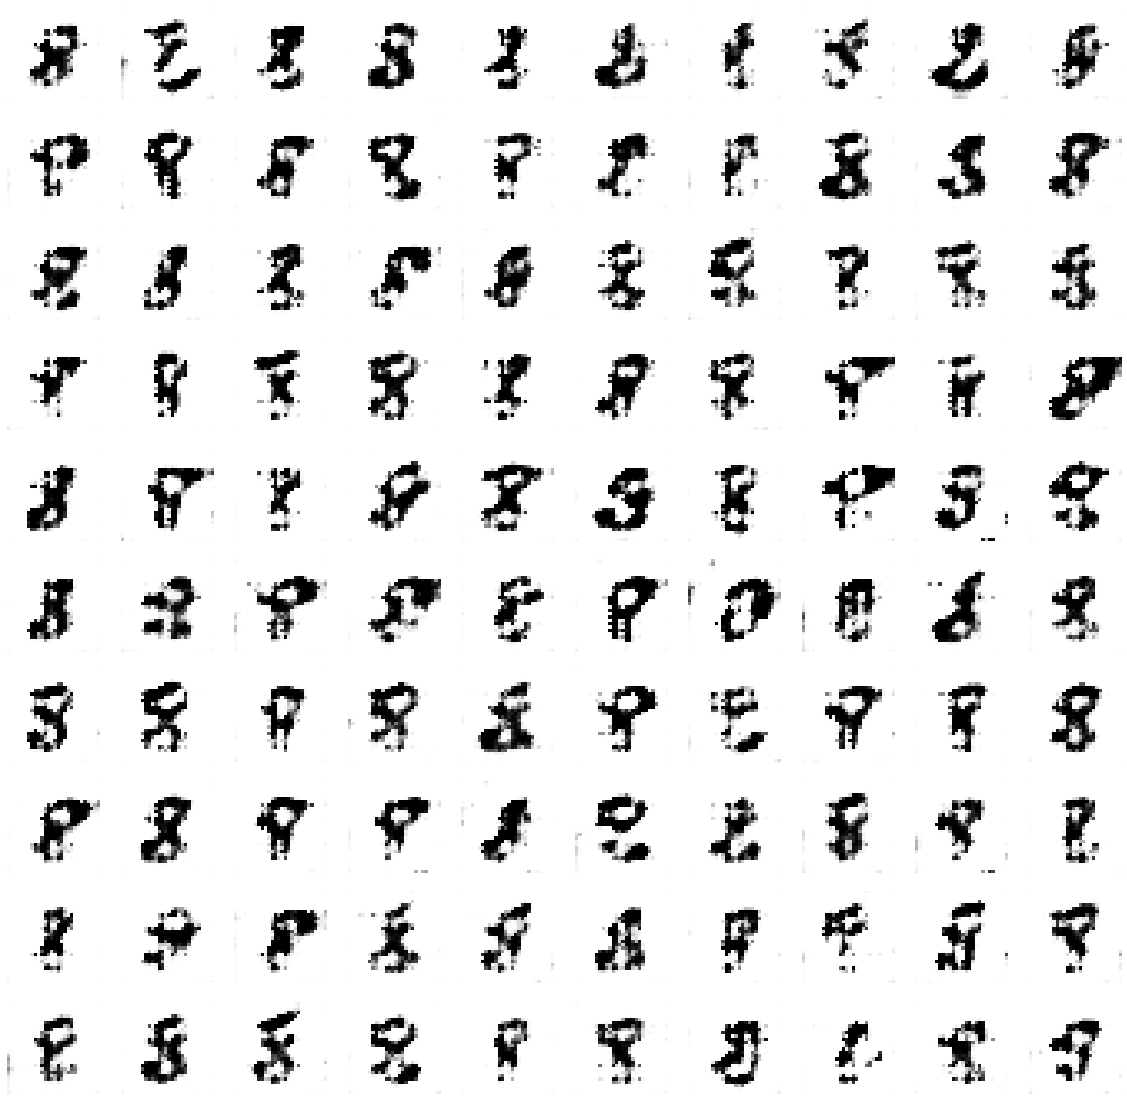

>406, d1=0.696, d2=0.705, g=0.770, a1=53, a2=42
>407, d1=0.707, d2=0.696, g=0.745, a1=51, a2=53
>408, d1=0.703, d2=0.700, g=0.743, a1=56, a2=45
>409, d1=0.690, d2=0.667, g=0.780, a1=53, a2=65
>410, d1=0.720, d2=0.724, g=0.740, a1=48, a2=45
>411, d1=0.704, d2=0.672, g=0.746, a1=51, a2=57
>412, d1=0.720, d2=0.693, g=0.758, a1=39, a2=51
>413, d1=0.727, d2=0.681, g=0.773, a1=48, a2=51
>414, d1=0.710, d2=0.666, g=0.772, a1=50, a2=60
>415, d1=0.693, d2=0.686, g=0.767, a1=51, a2=56
>416, d1=0.708, d2=0.674, g=0.782, a1=46, a2=56
>417, d1=0.706, d2=0.719, g=0.763, a1=48, a2=45
>418, d1=0.707, d2=0.716, g=0.758, a1=48, a2=54
>419, d1=0.701, d2=0.694, g=0.764, a1=42, a2=45
>420, d1=0.703, d2=0.688, g=0.739, a1=48, a2=54
>421, d1=0.680, d2=0.686, g=0.740, a1=62, a2=59
>422, d1=0.680, d2=0.692, g=0.756, a1=56, a2=51
>423, d1=0.704, d2=0.712, g=0.748, a1=50, a2=45
>424, d1=0.710, d2=0.704, g=0.756, a1=48, a2=48
>425, d1=0.689, d2=0.694, g=0.740, a1=57, a2=54
>426, d1=0.716, d2=0.690, g=0.750, a1=46

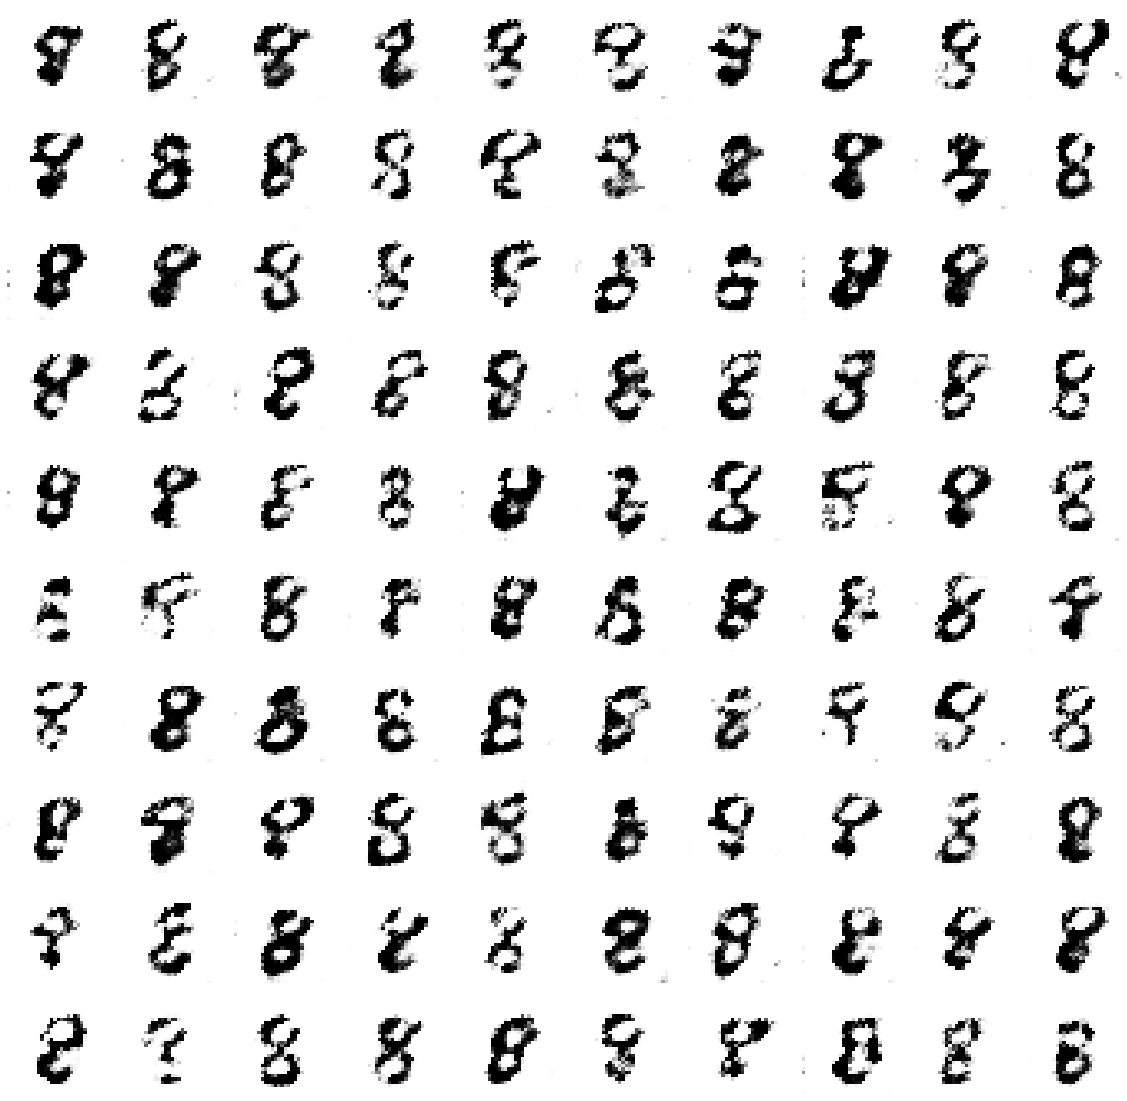

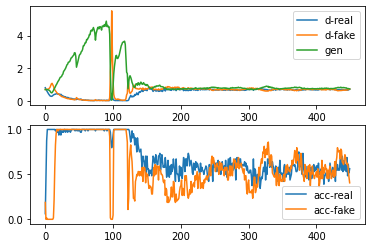

In [15]:
# make folder for results 
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)